### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [1]:
import matplotlib.pyplot as plt

print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):
  * проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;
  * достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [3]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.spatial import distance

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(y_hat):
    return np.log((y_hat/(1-y_hat)), 2)

class LogReg(BaseEstimator):
    def __init__(
            self,
            gd_type='stochastic',
            tolerance=1e-6,
            max_iter=10000,
            w0=None,
            eta=1e-3,
            batch=100,
            history=True,
    ):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        batch: size of minibatch
        history: if True then loss history will be calculated
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch = batch
        self.history = history
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # добавляем к Х столбец из 1
        if self.history:
            self.loss_history = []
        else:
            self.loss_history = None
        self.w = np.zeros(X.shape[1])
        if self.w0:
            self.w[0] = self.w0
        counts = X.shape[0]
        Xj, yj = X, y
        is_stochastic = (self.gd_type == 'stochastic')
        rng = np.random.default_rng()
        self.calc_loss(X, y)
        for i in range(self.max_iter):
            if is_stochastic:
                j = rng.integers(0, counts, size=self.batch)
                Xj, yj = X[j], y[j]
            new_w = self.w - self.eta * self.calc_gradient(Xj, yj)
            if distance.euclidean(self.w, new_w) < self.tolerance:
                self.calc_loss(X, y)
                break

            self.w = new_w
            self.calc_loss(X, y)

        return self

    @property
    def coef_(self):
        return self.w[1:]

    @property
    def intercept_fit_(self):
        return self.w[0]
    
    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # добавляем к Х столбец из 1
        return sigmoid(np.dot(X, self.w))

    
    def predict(self, X):
        yh = self.predict_proba(X)
        return (yh>0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        N = X.shape[0]
        yh = sigmoid(np.dot(X, self.w))
        grad = np.dot(X.T, (yh - y))
        grad = grad / N
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """
        if self.loss_history is None:
            return
        a = np.dot(X, model.w)
        # добавим 1e-9, чтобы избежать ошибки при log(0)
        loss = -np.mean(y * np.log(sigmoid(a) + 1e-9) + (1-y) * np.log(1 - sigmoid(a) + 1e-9))
        self.loss_history.append(loss)

    def __sklearn_is_fitted__(self):
        return self.w is not None


Синтетические данные

In [4]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [51]:
%%time
model = LogReg(gd_type='full')
model.fit(X_train, y_train)

CPU times: user 11min 28s, sys: 3min 25s, total: 14min 53s
Wall time: 2min 15s


LogReg(gd_type='full')

Подсчет loss_history занимает большое количество времени. Поэтому далее везде буду его отключать

In [7]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_score(y_test, y_pred)


0.8477021133847701

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.


In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
y_pred_probs = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_probs)

0.9257988615713604

In [9]:
average_precision_score(y_test, y_pred_probs)

0.9243491373923385

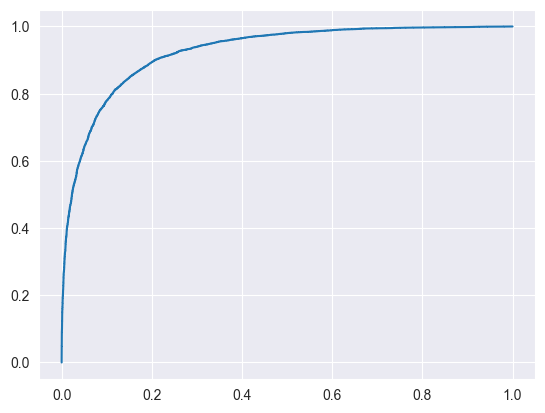

In [10]:
tpr, fpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(tpr, fpr)

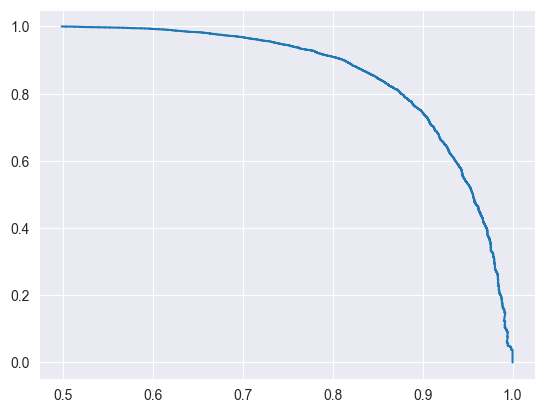

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.plot(precision, recall)

Графики ROC и PR показывают, что модель с высокой точностью предсказывает класс объекта.

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [38]:
data = pd.read_csv('train.csv.zip', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

In [13]:
data

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,9,1,5,8,0,1,1,0,0,1
9,1,1,7,0,0,0,0,1,0,0,...,3,1,1,9,0,1,1,0,1,0
13,5,4,9,1,0,0,0,1,0,0,...,4,2,7,7,0,1,1,0,1,0
16,0,1,2,0,0,1,0,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,2,0,1,0,1,0,0,0,0,...,3,1,1,3,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488013,3,1,10,0,0,0,0,0,1,0,...,4,1,9,6,0,1,1,0,1,1
1488016,5,1,3,0,0,0,0,0,1,0,...,4,1,3,8,1,0,1,0,1,1
1488017,1,1,10,0,0,1,0,0,0,0,...,3,2,2,6,0,0,1,0,0,0


Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [39]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.


In [41]:
%%time
model = LogReg(history=False)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred_proba)

CPU times: user 1.67 s, sys: 281 ms, total: 1.95 s
Wall time: 2.04 s


0.6151243408577906

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.


In [42]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = [
    column
    for column in X_train.columns
    if column.endswith('_cat')
]
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat_hot = encoder.fit_transform(X_train[categorical_columns])
X_train_cat_hot = pd.DataFrame(X_train_cat_hot, columns=encoder.get_feature_names_out())
X_train_cat_hot = pd.concat([X_train.drop(columns=categorical_columns), X_train_cat_hot], axis=1, join='inner')

X_test_cat_hot = encoder.transform(X_test[categorical_columns])
X_test_cat_hot = pd.DataFrame(X_test_cat_hot, columns=encoder.get_feature_names_out())
X_test_cat_hot = pd.concat([X_test.drop(columns=categorical_columns), X_test_cat_hot], axis=1, join='inner')

In [66]:
%%time
model = LogReg(history=False)
model.fit(X_train_cat_hot, y_train)

CPU times: user 19.1 s, sys: 10.8 s, total: 29.9 s
Wall time: 5.16 s


LogReg(history=False)

In [67]:
y_pred_proba = model.predict_proba(X_test_cat_hot)
roc_auc_score(y_test, y_pred_proba)

0.6221045593583058

Качество предсказания стало лучше

Как можно было заметить, one-hot-кодирование сильно увеличивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?



In [54]:
from sklearn.base import BaseEstimator, TransformerMixin


class AverageEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = {}

    def fit(self, X: pd.DataFrame, y):
        for label, values in X.items() :
            categories, counts = np.unique(values[y==1], return_counts=True)
            categories, total_counts = np.unique(values, return_counts=True)
            mapping = {category: value for category, value in zip(categories, counts / total_counts)}
            self.categories[label] = mapping
        return self

    def transform(self, X: pd.DataFrame):
        result = X.copy()
        for label, mapping in self.categories.items():
            result[label] = result[label].map(mapping)

        return result


encoder = AverageEncoder().fit(X_train[categorical_columns], y_train)
X_train_cat_target = encoder.transform(X_train)
X_test_cat_target = encoder.transform(X_test)

In [68]:
%%time
model = LogReg(history=False)
model.fit(X_train_cat_target, y_train)

CPU times: user 1.41 s, sys: 58.4 ms, total: 1.47 s
Wall time: 1.99 s


LogReg(history=False)

In [69]:
y_pred_proba = model.predict_proba(X_test_cat_target)
roc_auc_score(y_test, y_pred_proba)

0.6018767822670257

Качество предсказания заметно упало, но при этом обучение модели стало быстрее в 2 раза

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [70]:
class AverageRandomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories = {}

    def fit(self, X: pd.DataFrame, y):
        for label, values in X.items() :
            categories, counts = np.unique(values[y==1], return_counts=True)
            categories, total_counts = np.unique(values, return_counts=True)

            mapping = {
                category: value
                for category, value in zip(categories, counts / total_counts)
            }
            self.categories[label] = mapping
        return self

    def transform(self, X: pd.DataFrame):
        result = X.copy()
        N = len(result)
        rng = np.random.default_rng()
        for label, mapping in self.categories.items():
            result[label] = result[label].map(mapping) + (1 - rng.random(size=N) * 0.5)

        return result

encoder = AverageRandomEncoder().fit(X_train[categorical_columns], y_train)
X_train_cat_target1 = encoder.transform(X_train)
X_test_cat_target1 = encoder.transform(X_test)

In [71]:
%%time
model = LogReg(history=False)
model.fit(X_train_cat_target1, y_train)

CPU times: user 1.45 s, sys: 62.6 ms, total: 1.51 s
Wall time: 2.14 s


LogReg(history=False)

In [72]:
y_pred_proba = model.predict_proba(X_test_cat_target1)
roc_auc_score(y_test, y_pred_proba)

0.6011647966567731

Качество предсказания не изменилось по сравнению с AverageEncoder

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [74]:
data = pd.read_csv('train.csv.zip', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?


In [75]:
categorical_columns = [
    column
    for column in X_train.columns
    if column.endswith('_cat')
]
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat_hot = encoder.fit_transform(X_train[categorical_columns])
X_train_cat_hot = pd.DataFrame(X_train_cat_hot, columns=encoder.get_feature_names_out())
X_train_cat_hot = pd.concat([X_train.drop(columns=categorical_columns), X_train_cat_hot], axis=1, join='inner')

X_test_cat_hot = encoder.transform(X_test[categorical_columns])
X_test_cat_hot = pd.DataFrame(X_test_cat_hot, columns=encoder.get_feature_names_out())
X_test_cat_hot = pd.concat([X_test.drop(columns=categorical_columns), X_test_cat_hot], axis=1, join='inner')

In [27]:
len(X_train_cat_hot.columns)

213

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.


In [76]:
%%time
model = LogReg(history=False)
model.fit(X_train_cat_hot, y_train)

CPU times: user 19.4 s, sys: 11.5 s, total: 30.9 s
Wall time: 6.65 s


LogReg(history=False)

In [77]:
y_pred_proba = model.predict_proba(X_test_cat_hot)
roc_auc_score(y_test, y_pred_proba)

0.5420033083527748

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [78]:
features = np.argsort(model.coef_, kind='heapsort')[-200:]
X_train_embedded = X_train_cat_hot.iloc[:, features]
X_test_embedded = X_test_cat_hot.iloc[:, features]
model.fit(X_train_embedded, y_train)
y_pred_proba = model.predict_proba(X_test_embedded)
roc_auc_score(y_test, y_pred_proba)


0.4917829011170361

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [79]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cat_hot), columns=X_train_cat_hot.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_cat_hot), columns=X_test_cat_hot.columns)
model = LogReg(history=False)
model.fit(X_train_scaled, y_train)
features = np.argsort(model.coef_, kind='heapsort')[-200:]
X_train_embedded = X_train_scaled.iloc[:, features]
X_test_embedded = X_test_scaled.iloc[:, features]
model.fit(X_train_embedded, y_train)
y_pred_proba = model.predict_proba(X_test_embedded)
roc_auc_score(y_test, y_pred_proba)


0.4781689014314676

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [80]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_cat_hot), columns=X_train_cat_hot.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_cat_hot), columns=X_test_cat_hot.columns)
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train_scaled, y_train)
coefs = model.coef_[0]
coefs = coefs[coefs>0]
features = np.argsort(coefs, kind='heapsort')[-200:]
X_train_embedded = X_train_scaled.iloc[:, features]
X_test_embedded = X_test_scaled.iloc[:, features]
model = LogReg(history=False)
model.fit(X_train_embedded, y_train)
y_pred_proba = model.predict_proba(X_test_embedded)
roc_auc_score(y_test, y_pred_proba)

0.5405484627235344

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [81]:
%%time
class TStatisticSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=200):
        self.features = None
        self.n_features = n_features

    def fit(self, X: pd.DataFrame, y):
        X_plus = X[y==1]
        X_minus = X[y==0]
        mu_plus = X_plus.mean()
        mu_minus = X_minus.mean()
        sigma_plus = X_plus.var()
        sigma_minus = X_minus.var()
        n_plus = len(X_plus)
        n_minus = len(X_minus)
        t = np.abs(mu_plus - mu_minus) / np.sqrt(
            (n_plus * sigma_plus ** 2 + n_minus * sigma_minus ** 2)
            / (n_plus + n_minus)
        )
        self.features = t.nlargest(self.n_features).index
        return self

    def transform(self, X: pd.DataFrame):
        if self.features is None:
            raise ValueError('Not fitted')
        return X[self.features]

selector = TStatisticSelector()
X_train_filtered = selector.fit_transform(X_train_scaled, y_train)
X_test_filtered = selector.transform(X_test_scaled)

CPU times: user 2.11 s, sys: 1.52 s, total: 3.62 s
Wall time: 4.88 s


In [82]:
model = LogReg(history=False)
model.fit(X_train_filtered, y_train)
y_pred_proba = model.predict_proba(X_test_filtered)
roc_auc_score(y_test, y_pred_proba)

0.5666901476905133

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [35]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...